In [1]:
import numpy as np
import csv
import os
from math import sin, asin, cos, radians, fabs, sqrt
from matplotlib import pyplot as plt

In [2]:
ROOT = '/home/rick/PythonWorkplace/CIGIT2021/data/622/split'

In [3]:
paths = []
keys = ['date','number','condition','direction','location','speed',\
        'distance','coord','speed_inter','coord_inter']

In [4]:
for file in os.listdir(ROOT):
    file_path = os.path.join(ROOT, file)
    paths.append(file_path)

In [5]:
len(paths)

1999

# Difine distance computation func

In [6]:
EARTH_RADIUS = 6371

In [7]:
def hav(theta):
    s = sin(theta / 2)
    return s * s

In [8]:
def get_distance_hav(location_0, location_1):
    lat0 = radians(location_0[0])
    lng0 = radians(location_0[1])
    lat1 = radians(location_1[0])
    lng1 = radians(location_1[1])

    dlng = fabs(lng0 - lng1)
    dlat = fabs(lat0 - lat1)
    h = hav(dlat) + cos(lat0) * cos(lat1) * hav(dlng)
    distance = 2 * EARTH_RADIUS * asin(sqrt(h))

    return distance

# Read CSV

In [9]:
count = 0

for i in paths:
    tmp_name_dic = 'path%d' %count
    tmp_lst = []
    globals()[tmp_name_dic] = dict.fromkeys(keys,"")
    globals()[tmp_name_dic][keys[0]] = i[-25:-15]   # date
    globals()[tmp_name_dic][keys[1]] = i[-14:-8]    # number
    globals()[tmp_name_dic][keys[2]] = i[-7:-6]     # condition: 1 for first, 2 for last
    globals()[tmp_name_dic][keys[3]] = i[-5:-4]     # direction: 1 for up2dn, 2 for dn2up
    globals()[tmp_name_dic][keys[4]] = []    # location
    globals()[tmp_name_dic][keys[5]] = []    # speed
    globals()[tmp_name_dic][keys[6]] = [0]   # distance
    globals()[tmp_name_dic][keys[7]] = [0]   # coord
    count += 1
    
    with open(i, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            globals()[tmp_name_dic][keys[4]].append((float(row[1]),float(row[2])))  # location: (lati,longi)
            globals()[tmp_name_dic][keys[5]].append(float(row[3]))   # speed
    
    for y in range(1, len(globals()[tmp_name_dic][keys[4]])):
        tmp_d = get_distance_hav(globals()[tmp_name_dic][keys[4]][y-1],globals()[tmp_name_dic][keys[4]][y])
        tmp_d = round(tmp_d,2)
        globals()[tmp_name_dic][keys[6]].append(tmp_d)
        globals()[tmp_name_dic][keys[7]].append(round(globals()[tmp_name_dic][keys[7]][y-1] + tmp_d,2))
        
    globals()[tmp_name_dic][keys[6]] = np.array(globals()[tmp_name_dic][keys[6]])
    globals()[tmp_name_dic][keys[7]] = 1000 * np.array(globals()[tmp_name_dic][keys[7]])
    

# Interpolation

In [10]:
from scipy import interpolate

In [11]:
for i in range(count):
    tmp_name = 'path%d' %i
    x = globals()[tmp_name][keys[7]]
    y = globals()[tmp_name][keys[5]]
    f = interpolate.interp1d(x,y,kind='linear')
    xnew = np.linspace(0,int(x[-1]),int(x[-1]/10))
    globals()[tmp_name][keys[8]] = np.around(f(xnew), decimals=1)    # speed inter
    globals()[tmp_name][keys[9]] = np.around(xnew)       # coord inter

del xnew

# Framing

In [12]:
JN_dn2up = (29.631982, 106.553016)
TB = (29.755073, 106.627872)

JN_up2dn = (29.63154, 106.552032)
LJ = (29.758752, 106.631117)

In [13]:
dn2up = []
up2dn = []

In [14]:
for i in range(count):
    tmp_name = 'path%d' %i
    if globals()[tmp_name][keys[3]] == '1':   # up2dn
        if globals()[tmp_name][keys[4]][0][0] >= LJ[0] and globals()[tmp_name][keys[4]][0][1] >= LJ[1]:
            diff = 1000 * get_distance_hav(globals()[tmp_name][keys[4]][0], LJ)
            diff = np.around(diff, decimals=-1)
            y1 = globals()[tmp_name][keys[8]][int(diff/10):]
        else:
            y1 = globals()[tmp_name][keys[8]]
        
        if globals()[tmp_name][keys[4]][-1][0] <= JN_up2dn[0] and globals()[tmp_name][keys[4]][-1][1] <= JN_up2dn[1]:
            diff = 1000 * get_distance_hav(globals()[tmp_name][keys[4]][-1], JN_up2dn)
            diff = np.around(diff, decimals=-1)
            if diff <= 10.:
                diff = 10.
            y1 = y1[:-1*int(diff/10)]
        else:
            y1 = y1
        
        if len(y1) < 2000:    # 622全长24km，去掉头尾数站，将距离统一为19km，不符合要求的一律舍弃
            if len(y1) < 1900:
                pad = 1900-len(y1)
                y1 = np.pad(y1, (0,pad))
            else:
                y1 = y1[:1900]
            up2dn.append([y1,])
        else:
            continue
    
    if globals()[tmp_name][keys[3]] == '2':   #dn2up
        if globals()[tmp_name][keys[4]][0][0] <= JN_dn2up[0] and globals()[tmp_name][keys[4]][0][1] <= JN_dn2up[1]:
            diff = 1000 * get_distance_hav(globals()[tmp_name][keys[4]][0], JN_dn2up)
            diff = np.around(diff, decimals=-1)
            y2 = globals()[tmp_name][keys[8]][int(diff/10):]
        else:
            y2 = globals()[tmp_name][keys[8]]
        
        if globals()[tmp_name][keys[4]][-1][0] >= TB[0] and globals()[tmp_name][keys[4]][-1][1] >= TB[1]:
            diff = 1000 * get_distance_hav(globals()[tmp_name][keys[4]][-1], TB)
            diff = np.around(diff, decimals=-1)
            if diff <= 10.:
                diff = 10.
            y2 = y2[:-1*int(diff/10)]
        else:
            y2 = y2
            
        dn2up.append(y2)


In [25]:
for row in dn2up:
    

34.0
30.8
27.7
24.5
21.3
18.2
0.0
2.1
4.3
6.4
8.5
10.7
12.8
14.9
17.1
19.2
21.4
23.5
25.6
27.8
29.9
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
31.9
28.4
24.8
21.3
17.7
14.2
10.6
7.0
3.5
0.2
7.7
15.0
15.5
15.9
16.4
16.8
17.3
17.8
18.2
18.7
19.1
19.6
20.0
20.5
21.0
21.4
21.9
22.3
22.8
23.2
23.7
24.2
24.6
25.1
25.5
26.0
26.4
26.9
27.4
27.8
28.3
28.7
29.2
29.6
30.1
30.6
31.0
31.5
31.9
32.4
32.8
33.2
33.7
34.1
34.6
35.0
34.9
32.9
30.9
28.9
26.9
24.9
22.9
20.0
0.1
1.6
3.2
4.8
6.4
7.9
9.5
11.1
12.7
14.2
15.8
17.4
18.9
20.5
22.1
23.7
25.2
26.8
28.4
30.0
31.5
33.0
32.9
32.8
32.7
32.6
32.5
32.4
32.3
32.2
32.1
32.0
32.2
32.3
32.5
32.7
32.8
33.0
33.2
33.3
33.5
33.7
33.8
34.0
34.2
34.3
34.5
34.7
34.8
35.0
35.0
35.0
35.0
35.0
35.0
35.0
35.0
34.9
33.9
32.6
28.1
23.6
19.1
15.3
18.8
22.1
22.7
23.4
24.1
24.9
25.8
26.6
27.5
28.4
29.2
30.0
30.2
30.5
30.7
30.9
31.1
31.4
31.6
31.8
32.0
32.1
32.3
32.4
32.5
32.6
32.8
32.9
32.4
25.8
19.1
12.5
5.9
0.5
5.9
11.3
16.8
22.2
27.3
29.9
32.6
34.5
30.2
25.8
21.4
17.0
12.7

In [38]:
path0[keys[8]]

array([34. , 30.8, 27.7, ..., 20.3, 16.7, 13. ])

In [28]:
dn2up

[array([ 0. ,  2.1,  4.3, ..., 20.3, 16.7, 13. ]),
 array([14.5,  7.2,  0.1, ..., 35.6, 35.3, 35. ]),
 array([16. , 14. , 12. , ..., 23.7, 19.4, 15. ]),
 array([18. , 18.3, 18.7, ..., 12.5,  8.3,  4.2]),
 array([ 5.3,  0. ,  5.8, ..., 37. , 37. , 37. ]),
 array([23. , 23. , 23. , ..., 25.8, 20.5, 15.3]),
 array([24.4, 21.6, 18.8, ..., 34.3, 34.1, 34. ]),
 array([28.2, 24.8, 21.4, ..., 34.7, 34.4, 34. ]),
 array([20. , 20.7, 21.3, ..., 23.5, 20. , 16.5]),
 array([18. , 19.5, 20.9, ..., 25. , 21. , 17. ]),
 array([22.4, 22.7, 23.1, ..., 32.3, 32.1, 32. ]),
 array([ 6.7,  0. ,  4.4, ..., 38.8, 39.4, 40. ]),
 array([13. , 13.3, 13.5, ..., 23.9, 20.6, 17.3]),
 array([16. , 17.2, 18.3, ..., 28.1, 27. , 13.6]),
 array([ 4.8,  0. ,  9.6, ..., 34.8, 34.9, 35. ]),
 array([4. , 0. , 5.3, ..., 4.8, 3.2, 1.6]),
 array([27. , 24.3, 21.6, ..., 21.3, 18.6, 16. ]),
 array([ 0. ,  5.3, 10.5, ..., 34.3, 33.7, 33. ]),
 array([26. , 22.7, 19.5, ..., 31. , 25.3, 19.7]),
 array([14. , 14.8, 15.7, ...,  4.2, 

In [31]:
for i in dn2up:
    if len(i) < 2000:
        print(len(i))
        

1887
1870
1876
1872
1872
1855
1828
1876
1827
1868
1862
1819
1869
1860
1865
1861
1866
1849
1975
1863
1851
1835
1864
1830
1898
1867
1853
1839
1893
1858
1976
1847
1871
1837
1865
1864
1868
1900
1850
1864
1875
1872
1881
1884
1857
1869
1851
1864
1868
1880
1873
1864
1868
1849
1869
1882
1882
1872
1859
1852
1857
1852
1885
1855
1875
1944
1836
1846
1875
1879
1849
1883
1880
1881
1944
1861
1866
1861
1863
1856
1856
1869
1855
1853
1909
1879
1857
1859
1848
1991
1881
1877
1874
1854
1878
1870
1875
1941
1867
1870
1928
1878
1872
1900
1856
1912
1879
1858
1873
1849
1874
1870
1903
1861
1860
1842
1893
1867
1860
1885
1877
1869
1869
1832
1883
1889
1882
1865
1866
1862
1870
1880
1879
1832
1868
1883
1878
1864
1948
1857
1905
1856
1866
1861
1852
1863
1871
1845
1867
1881
1856
1854
1875
1852
1879
1928
1867
1867
1848
1876
1882
1853
1850
1848
1917
1888
1940
1922
1847
1862
1867
1863
1879
1865
1867
1866
1887
1881
1876
1877
1879
1869
1883
1867
1831
1897
1825
1836
1887
1879
1846
1842
1890
1856
1884
1865
1871
1914
1869
1884


In [61]:
sf = open('up2dn.txt','w')
sf.write(str(up2dn))
sf.close()

TypeError: 'str' object is not callable

In [59]:
dn2up

[array([ 0. ,  2.1,  4.3, ..., 20.3, 16.7, 13. ]),
 array([14.5,  7.2,  0.1, ..., 35.6, 35.3, 35. ]),
 array([16. , 14. , 12. , ..., 23.7, 19.4, 15. ]),
 array([18. , 18.3, 18.7, ..., 12.5,  8.3,  4.2]),
 array([ 5.3,  0. ,  5.8, ..., 37. , 37. , 37. ]),
 array([23. , 23. , 23. , ..., 25.8, 20.5, 15.3]),
 array([24.4, 21.6, 18.8, ..., 34.3, 34.1, 34. ]),
 array([28.2, 24.8, 21.4, ..., 34.7, 34.4, 34. ]),
 array([20. , 20.7, 21.3, ..., 23.5, 20. , 16.5]),
 array([18. , 19.5, 20.9, ..., 25. , 21. , 17. ]),
 array([22.4, 22.7, 23.1, ..., 32.3, 32.1, 32. ]),
 array([ 6.7,  0. ,  4.4, ..., 38.8, 39.4, 40. ]),
 array([13. , 13.3, 13.5, ..., 23.9, 20.6, 17.3]),
 array([16. , 17.2, 18.3, ..., 28.1, 27. , 13.6]),
 array([ 4.8,  0. ,  9.6, ..., 34.8, 34.9, 35. ]),
 array([4. , 0. , 5.3, ..., 4.8, 3.2, 1.6]),
 array([27. , 24.3, 21.6, ..., 21.3, 18.6, 16. ]),
 array([ 0. ,  5.3, 10.5, ..., 34.3, 33.7, 33. ]),
 array([26. , 22.7, 19.5, ..., 31. , 25.3, 19.7]),
 array([14. , 14.8, 15.7, ...,  4.2, 

In [1]:
str(3)

'3'

In [29]:
keys

['date',
 'number',
 'condition',
 'direction',
 'location',
 'speed',
 'distance',
 'coord',
 'speed_inter',
 'coord_inter']

In [26]:
a = np.array([32.63,46.2,89.111])

In [67]:
for i in a:
    print(str(i))

TypeError: 'str' object is not callable

In [38]:
a[1:]

array([46.2  , 89.111])

In [34]:
c = 3.2
d = np.around(c,decimals=-1)
d

0.0

In [20]:
with open(file_stop_up2dn, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        tmp_tuple = (float(row[1]),float(row[2]))
        tmp_lst1 = [row[0]]
        tmp_lst1.append(tmp_tuple)
        stop_up2dn.append(tmp_lst1)      

In [21]:
with open(file_stop_dn2up, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        tmp_tuple = (float(row[1]),float(row[2]))
        tmp_lst2 = [row[0]]
        tmp_lst2.append(tmp_tuple)
        stop_dn2up.append(tmp_lst2)  

In [ ]:
get_distance_hav(path130[keys[4]][0], ())

In [25]:
for i in range(count):
    tmp_name = 'path%d' %i
    
    # 修正起始点
    if globals()[tmp_name][keys[3]] == 1:   # up2dn
        if get_distance_hav(globals()[tmp_name][keys[4]][0],globals()[tmp_name][keys[4]][1])

1999

In [27]:
keys

['date',
 'number',
 'condition',
 'direction',
 'location',
 'speed',
 'distance',
 'coord',
 'speed_inter',
 'coord_inter']

In [28]:
path139[keys[4]]

[(29.63156215594073, 106.55241814874715),
 (29.63191295348025, 106.55304200249824),
 (29.631955676525564, 106.55318174585756),
 (29.631977643272336, 106.5532007120457),
 (29.632264991709278, 106.55355507581888),
 (29.632691499524512, 106.55434466471975),
 (29.63312498405842, 106.5551582383374),
 (29.63334323084984, 106.55556753157536),
 (29.63352547433132, 106.55597682996529),
 (29.633711963935113, 106.55626334666387),
 (29.63438074456173, 106.55750828032036),
 (29.63470665915922, 106.55812827651444),
 (29.634960823352166, 106.55861150610048),
 (29.635683555504954, 106.55995242463553),
 (29.635832938894367, 106.56031687031191),
 (29.63597024805771, 106.56072425614767),
 (29.636060135039543, 106.56080114486588),
 (29.637027516209958, 106.56245076669974),
 (29.63748618388034, 106.56330957634744),
 (29.638470333105445, 106.56521006470605),
 (29.63878620484015, 106.56597609650235),
 (29.63889089704101, 106.56619083113173),
 (29.639038623786554, 106.56639158799351),
 (29.639116437231287, 10

In [26]:
path139[keys[9]]

array([0.00000000e+00, 1.00052994e+01, 2.00105988e+01, ...,
       1.88599894e+04, 1.88699947e+04, 1.88800000e+04])

In [147]:
len(path139[keys[9]])

1888

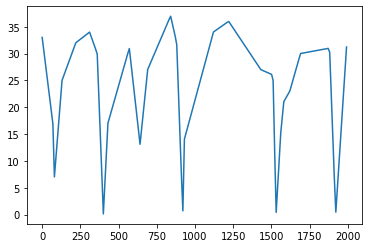

In [148]:
plt.plot(path139[keys[9]][:200], path139[keys[8]][:200])

In [11]:
a = [['1','2','3'],
    ['2','42','1']]

In [12]:
string = '\n'
f=open("k.txt","w")
f.write(string.join(a))
f.close()

TypeError: sequence item 0: expected str instance, list found

In [32]:
a = ['321']
b = (143.2,12433)

In [33]:
a.append(b)

In [35]:
a.append([a,b])

In [36]:
a

['321', (143.2, 12433), [[...], (143.2, 12433)]]